In [1]:
import pandas as pd
import numpy as np

from surprise import accuracy, Dataset, SVD, Reader
from surprise.model_selection import train_test_split, cross_validate

import string

food_data = pd.read_csv('data/food.csv')
ratings_data = pd.read_csv('data/ratings.csv')

def text_cleaning(text):
    text = "".join([char for char in text if char not in string.punctuation])
    return text
food_data['Describe'] = food_data['Describe'].apply(text_cleaning)

def create_soup(x):
  return " ".join([x['Describe'], x['C_Type'], x['Veg_Non']])

food_data['soup'] = food_data.apply(create_soup, axis=1)

reader = Reader(rating_scale=(1, 10))

merged_data = pd.merge(ratings_data, food_data, on='Food_ID')
data = Dataset.load_from_df(merged_data[['User_ID', 'Food_ID', 'Rating']], reader)

# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

# We'll use the famous SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 3.0032


3.003190648846871

In [2]:
predictions

[Prediction(uid=32.0, iid=143.0, r_ui=1.0, est=5.193014306652861, details={'was_impossible': False}),
 Prediction(uid=93.0, iid=130.0, r_ui=5.0, est=6.1405028630404885, details={'was_impossible': False}),
 Prediction(uid=63.0, iid=269.0, r_ui=3.0, est=6.299633850072069, details={'was_impossible': False}),
 Prediction(uid=13.0, iid=74.0, r_ui=8.0, est=5.646970880735349, details={'was_impossible': False}),
 Prediction(uid=6.0, iid=22.0, r_ui=5.0, est=5.222286624734076, details={'was_impossible': False}),
 Prediction(uid=94.0, iid=48.0, r_ui=3.0, est=5.315109984186112, details={'was_impossible': False}),
 Prediction(uid=11.0, iid=200.0, r_ui=10.0, est=5.538635691004665, details={'was_impossible': False}),
 Prediction(uid=86.0, iid=159.0, r_ui=2.0, est=5.124173710404215, details={'was_impossible': False}),
 Prediction(uid=100.0, iid=24.0, r_ui=10.0, est=5.129298919924888, details={'was_impossible': False}),
 Prediction(uid=41.0, iid=4.0, r_ui=6.0, est=5.442787137062538, details={'was_impos

Demonstration about how to predict the rating for the user with id=80 and item with id=2

In [3]:
algo.predict(80.0, 2.0)

Prediction(uid=80.0, iid=2.0, r_ui=None, est=5.5126416353111125, details={'was_impossible': False})

In [4]:
user_id = 80.0

def get_user_recommendations(user_id, n=5):
    predictions = []
    for item in merged_data['Food_ID'].unique():
        predictions.append(algo.predict(user_id, item))
    
    best_items = sorted([(prediction.iid, prediction.est) for prediction in predictions], key=lambda x: x[1])[::-1][:n]
    best_items_idx = [x for x, y in best_items]
    rec_items = food_data.loc[best_items_idx]
    return rec_items['Name']

print(get_user_recommendations(user_id, n=5))

49                       french pork chop
44     ghee roast chicken dosa quesadilla
109          chicken and mushroom lasagna
215       duo of chocolate and strawberry
171                  zucchini methi pulao
Name: Name, dtype: object


## Fine-tuning

In [5]:
from surprise.model_selection import GridSearchCV

param_grid = {
  'n_factors': [20, 50, 100, 200, 400, 800, 1000],
  'n_epochs': [5, 10, 20, 50, 100, 200]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=10)
gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

2.8559858325358674
{'n_factors': 800, 'n_epochs': 10}


In [6]:
best_factor = gs.best_params['rmse']['n_factors']
best_epoch = gs.best_params['rmse']['n_epochs']

# We'll use the famous SVD algorithm.
svd = SVD(n_factors=best_factor, n_epochs=best_epoch)

# Train the algorithm on the trainset
svd.fit(trainset)

In [7]:
cv = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.6290  3.0346  2.6553  2.8752  3.1535  2.8695  0.2058  
MAE (testset)     2.2021  2.7072  2.2703  2.4668  2.7122  2.4717  0.2129  
Fit time          0.01    0.01    0.01    0.01    0.01    0.01    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


### Analyzing predictions

In [9]:
predictions = svd.test(testset)
predictions

[Prediction(uid=32.0, iid=143.0, r_ui=1.0, est=5.299623370814367, details={'was_impossible': False}),
 Prediction(uid=93.0, iid=130.0, r_ui=5.0, est=5.373293219906932, details={'was_impossible': False}),
 Prediction(uid=63.0, iid=269.0, r_ui=3.0, est=4.065376199736819, details={'was_impossible': False}),
 Prediction(uid=13.0, iid=74.0, r_ui=8.0, est=5.465541215425058, details={'was_impossible': False}),
 Prediction(uid=6.0, iid=22.0, r_ui=5.0, est=5.1462135402896285, details={'was_impossible': False}),
 Prediction(uid=94.0, iid=48.0, r_ui=3.0, est=3.982249337215643, details={'was_impossible': False}),
 Prediction(uid=11.0, iid=200.0, r_ui=10.0, est=5.093476381844224, details={'was_impossible': False}),
 Prediction(uid=86.0, iid=159.0, r_ui=2.0, est=3.17013215446011, details={'was_impossible': False}),
 Prediction(uid=100.0, iid=24.0, r_ui=10.0, est=8.603361799671033, details={'was_impossible': False}),
 Prediction(uid=41.0, iid=4.0, r_ui=6.0, est=5.587617424537421, details={'was_imposs

In [12]:
ratings = {k: 0 for k in range(1, 10+1)}

for pred in predictions:
    ratings[round(pred.est)]+=1

ratings

{1: 0, 2: 1, 3: 14, 4: 19, 5: 36, 6: 24, 7: 9, 8: 22, 9: 3, 10: 0}

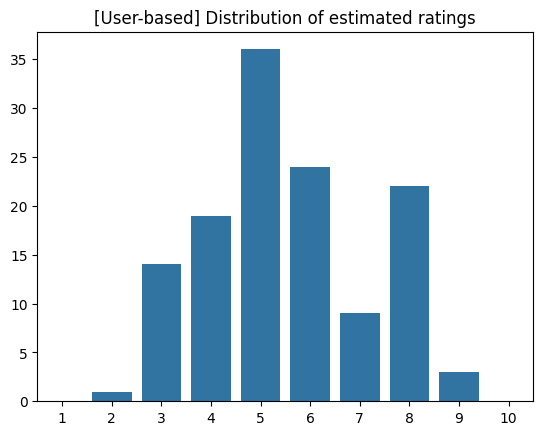

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(ratings)
plt.title("[User-based] Distribution of estimated ratings");